📁 Arquivo Excel gerado com sucesso.


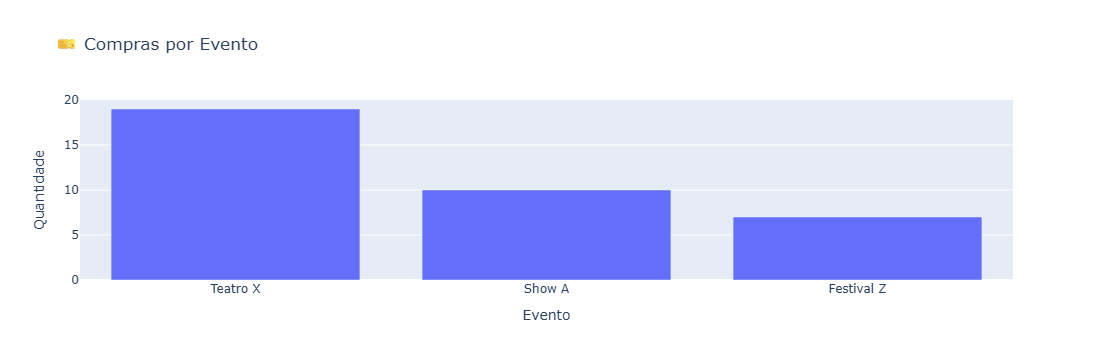

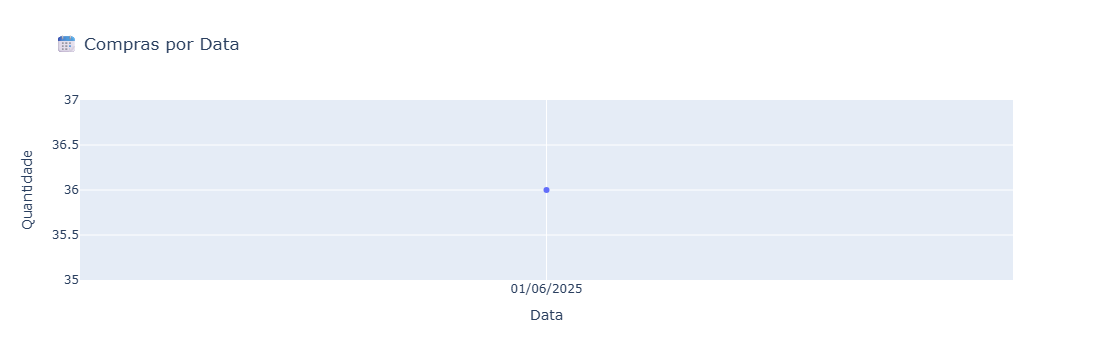

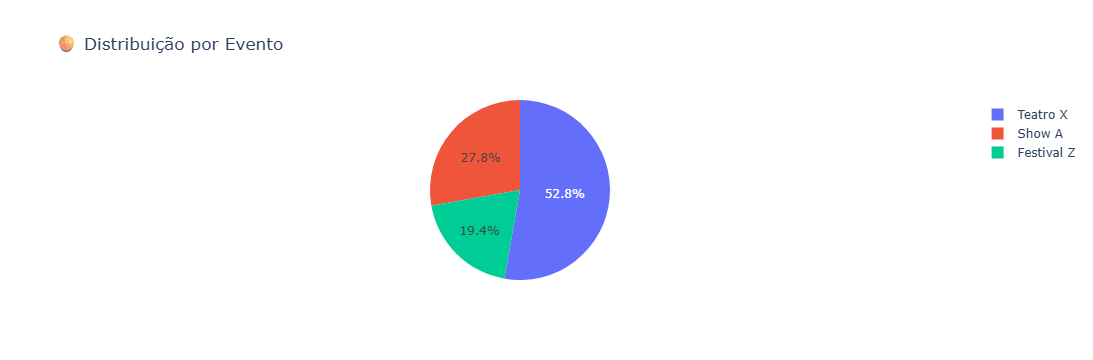

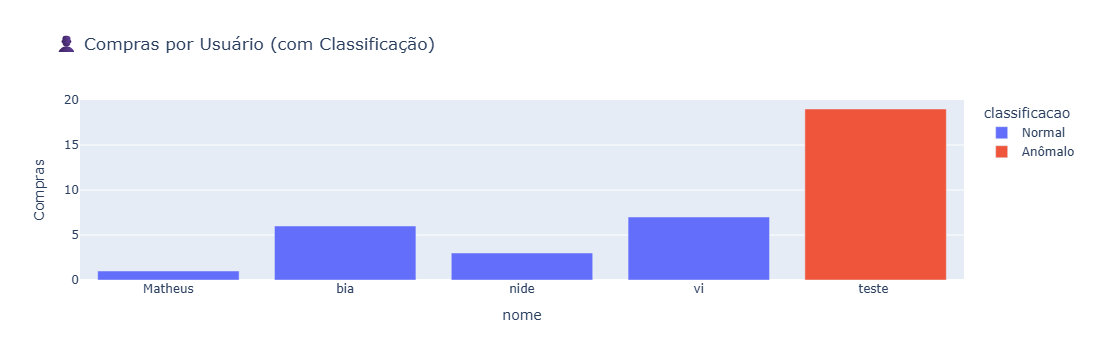


✅ Pipeline finalizada com sucesso!
    usuario_id     nome classificacao
0            1     nide        Normal
3            2       vi        Normal
10           3  Matheus        Normal
11           4   teste        Anômalo
30           5      bia        Normal


In [1]:
import sqlite3
import pandas as pd
import plotly.express as px
from sklearn.ensemble import IsolationForest

# 📥 Carregar dados de compras de ingressos com classificação por IA
def carregar_dados_ingressos_com_ia():
    conn = sqlite3.connect("../database.db")  # Ajuste o caminho se necessário
    query = """
        SELECT u.id AS usuario_id, u.nome, u.email, l.acao_usuario AS acao, l.data_hora
        FROM logs l
        JOIN usuarios u ON u.id = l.usuario_id
        WHERE l.acao_usuario LIKE 'Compra do ingresso ID%'
    """
    df = pd.read_sql_query(query, conn)
    conn.close()

    # Converter data_hora para datetime
    df['data_hora'] = pd.to_datetime(df['data_hora'])

    # → AQUI: em vez de gerar “Ingresso X”, extrair o ID e buscar o nome real
    # 1️⃣ Extrair o ingresso_id a partir de "Compra do ingresso ID X"
    df['ingresso_id'] = (
        df['acao']
        .str.replace("Compra do ingresso ID ", "")  # remove o prefixo textual
        .astype(int)                                 # converte pra inteiro
    )

    # 2️⃣ Carregar tabela de ingressos para obter o nome real do evento
    conn2 = sqlite3.connect("../database.db")
    df_ingressos = pd.read_sql_query(
        "SELECT id AS ingresso_id, nome_evento FROM ingressos", conn2
    )
    conn2.close()

    # 3️⃣ Fazer merge para trazer nome_evento ao DataFrame principal
    df = df.merge(df_ingressos, on='ingresso_id', how='left')

    # 4️⃣ Definir a coluna 'evento' como sendo o nome real do evento
    df['evento'] = df['nome_evento']

    # 5️⃣ Extrair a data (sem hora) para agrupamentos posteriores
    df['data'] = df['data_hora'].dt.date

    # 🧠 Isolation Forest — igual ao original
    df_features = df.groupby(['usuario_id', 'nome', 'email']).agg(
        total_compras=('evento', 'count'),
        dias_diferentes=('data', pd.Series.nunique)
    ).reset_index()

    modelo = IsolationForest(contamination=0.15, random_state=42)
    df_features['classificacao'] = modelo.fit_predict(
        df_features[['total_compras', 'dias_diferentes']]
    )
    df_features['classificacao'] = df_features['classificacao'].map({1: 'Normal', -1: 'Anômalo'})

    df = pd.merge(df, df_features[['usuario_id', 'classificacao']], on='usuario_id', how='left')
    return df

# 📊 Exibir gráficos
def exibir_graficos(df):
    # 1️⃣ Contagem de compras por evento (agora 'evento' tem o nome real)
    contagem_eventos = df['evento'].value_counts().reset_index()
    contagem_eventos.columns = ['Evento', 'Quantidade']
    px.bar(
        contagem_eventos,
        x='Evento',
        y='Quantidade',
        title='🎫 Compras por Evento'
    ).show()

    # 2️⃣ Evolução de compras por data
    compras_por_data = df['data'].value_counts().sort_index().reset_index()
    compras_por_data.columns = ['Data', 'Quantidade']
    compras_por_data['Data'] = compras_por_data['Data'].apply(lambda d: d.strftime('%d/%m/%Y'))
    px.line(
        compras_por_data,
        x='Data',
        y='Quantidade',
        markers=True,
        title='📆 Compras por Data'
    ).show()

    # 3️⃣ Distribuição de compras por evento (pizza)
    px.pie(
        contagem_eventos,
        names='Evento',
        values='Quantidade',
        title='🥧 Distribuição por Evento'
    ).show()

    # 4️⃣ Compras por usuário, já coloridas conforme 'classificacao'
    compras_por_usuario = (
        df.groupby(['nome', 'classificacao'])['evento']
        .count()
        .reset_index(name='Compras')
    )
    px.bar(
        compras_por_usuario,
        x='nome',
        y='Compras',
        color='classificacao',
        title='👤 Compras por Usuário (com Classificação)'
    ).show()

# 🚀 Executar pipeline
def executar_pipeline():
    df = carregar_dados_ingressos_com_ia()

    # Salvar CSV e Excel
    df.to_csv("compras_ingressos_ia.csv", index=False, encoding="utf-8-sig")
    try:
        df.to_excel("compras_ingressos_ia.xlsx", index=False)
        print("📁 Arquivo Excel gerado com sucesso.")
    except Exception as e:
        print(f"⚠️ Erro ao gerar Excel: {e}")

    # Exibir os gráficos
    exibir_graficos(df)

    # Mensagem final e resumo de classificações
    print("\n✅ Pipeline finalizada com sucesso!")
    print(df[['usuario_id', 'nome', 'classificacao']].drop_duplicates())

# ▶️ Rodar como script principal
if __name__ == "__main__":
    executar_pipeline()
